In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/val-en-df/validation_en.csv
/kaggle/input/jigsawmultilingual/jigsaw_miltilingual_test_translated.csv
/kaggle/input/test-en-df/test_en.csv


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

In [3]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [4]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [5]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [7]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [8]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

valid = pd.read_csv('/kaggle/input/val-en-df/validation_en.csv')
test1 = pd.read_csv('/kaggle/input/test-en-df/test_en.csv')
test2 = pd.read_csv('/kaggle/input/jigsawmultilingual/jigsaw_miltilingual_test_translated.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

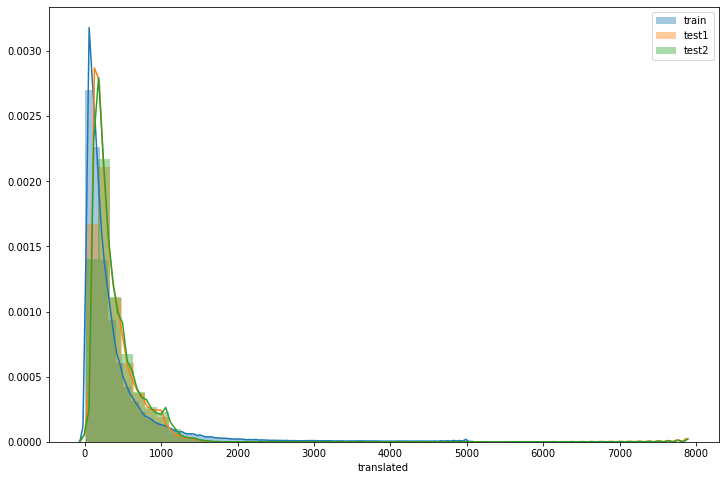

In [9]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.legend()

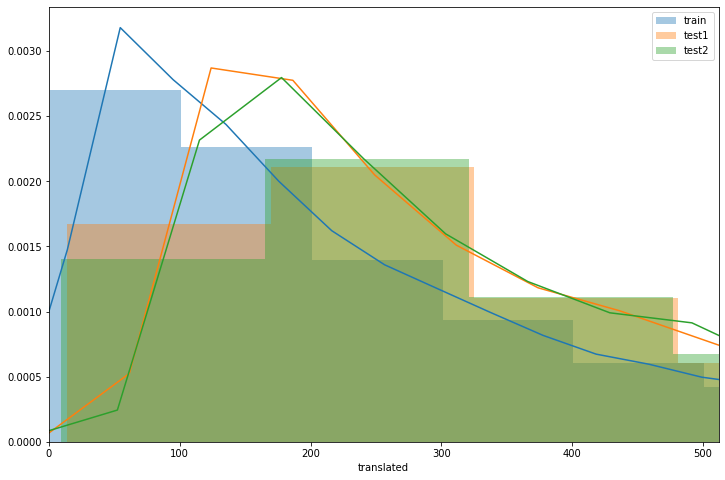

In [10]:
plt.figure(figsize=(12, 8))

sns.distplot(train1.comment_text.str.len(), label='train')
sns.distplot(test1.content_en.str.len(), label='test1')
sns.distplot(test2.translated.str.len(), label='test2')
plt.xlim([0, 512])
plt.legend()

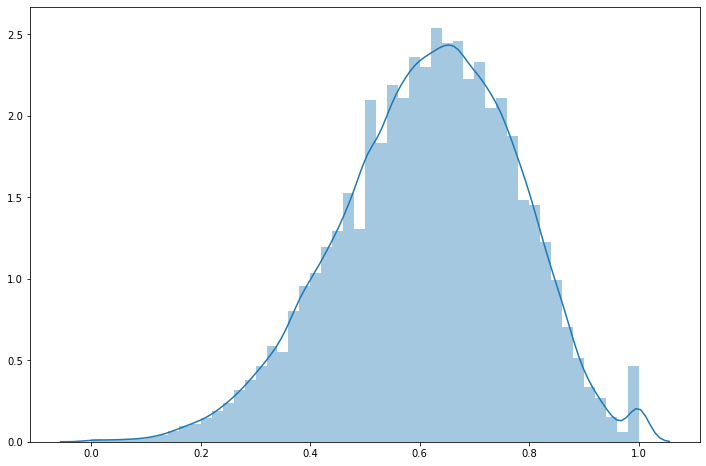

In [11]:
test_set_similarity = [cosine_sim(t1, t2) for t1, t2 in tqdm(zip(test1.content_en, test2.translated))]

plt.figure(figsize=(12, 8))

sns.distplot(test_set_similarity)

In [12]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_valid = fast_encode(valid.comment_text_en.astype(str), fast_tokenizer, maxlen=512)
x_test1 = fast_encode(test1.content_en.astype(str), fast_tokenizer, maxlen=512)
x_test2 = fast_encode(test2.translated.astype(str), fast_tokenizer, maxlen=512)

y_train = train1.toxic.values
y_valid = valid.toxic.values

In [13]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(64)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(64)
    .cache()
    .prefetch(AUTO)
)

test_dataset = [(
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(64)
),
    (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(64)
)]

In [14]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [15]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________
CPU times: user 26.2 s, sys: 6.13 s, total: 32.3 s
Wall time: 41.4 s


In [16]:
from tensorflow.keras.callbacks import Callback 

class RocAucCallback(Callback):
    def __init__(self, test_data, score_thr):
        self.test_data = test_data
        self.score_thr = score_thr
        self.test_pred = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_auc'] > self.score_thr:
            print('\nRun TTA...')
            for td in self.test_data:
                self.test_pred.append(self.model.predict(td))

In [17]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

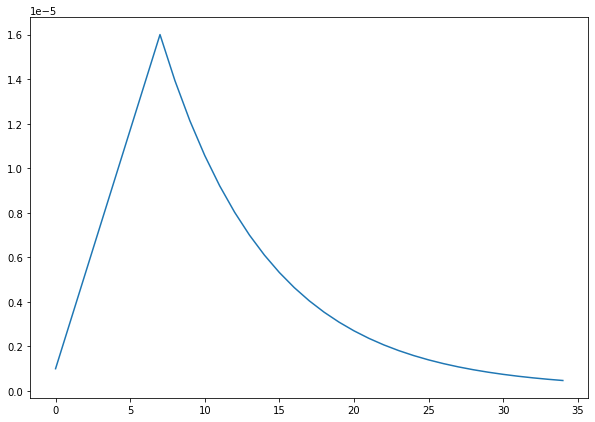

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)])

In [19]:
roc_auc = RocAucCallback(test_dataset, 0.9195)
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

train_history = model.fit(
    train_dataset,
    steps_per_epoch=150,
    validation_data=valid_dataset,
    callbacks=[lr_schedule, roc_auc],
    epochs=35
)

Train for 150 steps, validate for 125 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/35
150/150 [==============================] - 135s 897ms/step - loss: 0.0424 - auc: 0.5539 - val_loss: 0.0603 - val_auc: 0.6419

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/35
150/150 [==============================] - 42s 281ms/step - loss: 0.0319 - auc: 0.7728 - val_loss: 0.0481 - val_auc: 0.8429

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/35
150/150 [==============================] - 42s 279ms/step - loss: 0.0210 - auc: 0.9271 - val_loss: 0.0370 - val_auc: 0.9012

Epoch 00004: LearningRateScheduler reducing learning rate to 7.4285714285714275e-06.
Epoch 4/35
150/150 [==============================] - 42s 279ms/step - loss: 0.0153 - auc: 0.9637 - val_loss: 0.0428 - val_auc: 0.9108

Epoch 00005: LearningRateScheduler reducing learning rate to 9.571428571428572e-06.
Epoch

In [20]:
sub['toxic'] = np.mean(roc_auc.test_pred, axis=0)
sub.to_csv('submission.csv', index=False)